# Summarization query oriented

 <hr style="border-color:#1d539d"> 

## Initialization

In [8]:
import bisect
import collections
import copy
import gensim
import json
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import random
import time

In [9]:
# paths to folders

data_json = "/home/ubuntu/summarization_query_oriented/data/json/patch_0/"
data_txt = "/home/ubuntu/summarization_query_oriented/data/txt/"
model_folder = "/home/ubuntu/summarization_query_oriented/models/"
nn_models_folder = "/home/ubuntu/summarization_query_oriented/nn_models/"

## Doc2vec

In [10]:
# parameters of doc2vec
dm = 0
min_count = 5
window = 10
size = 400
sample = 1e-4
negative = 5
workers = 4
epoch = 20

# Initialize the model ( IMPORTANT )
d2v_model = gensim.models.doc2vec.Doc2Vec(dm=dm,min_count=min_count, window=window, size=size, sample=sample, negative=negative, workers=workers,iter = epoch)

# load model
model_name ="dm_"+str(dm)+"_mc_"+str(min_count)+"_w_"+str(window)+"_size_"+str(size)+"_neg_"+str(negative)+"_ep_"+str(epoch)
d2v_model = d2v_model.load(model_folder+model_name+".d2v")
print("model loaded")

model loaded


## Models 

### Model 1 : fully connected model


* __Architecture__ : Fully connected model


* __Input__ : a vector that is the concatenation of [ query , partial summary, candidate ]
    * *query* : here the subtitle of a wikipedia page
    * *partial summary* : here a part (eventually void) of the summary attached to this subtitle
    * *candidate* : a random sentence


* __Output__ : a score describing how much the candidate sentence is completing the partial summary w.r.t the query 


* __Training mode__ : we sample triplet from wikipedia data to build the training set, we label 1 if the candidate sentence is a sentence of the correct subsection that is not in the partial summary (by building), we label 0 otherwise


* __Testing mode__ : Given a document and a query. The partial summary is initialized as the query, then we choose the sentence of the document that is not in the partial summary with the highest score and delete it from the document. We repeat it until we reach the length limit

#### Data Processing 

Here we build functions to perform end—to-end data preparation

In [11]:
# functions

non_selected_keys = ["title", "external links","further reading","references","see also"]

def has_at_least_one_relevant_key(file_as_dict):
    
    for key in file_as_dict.keys():
        b = True
        for unwanted_key in non_selected_keys:
            if unwanted_key in key.lower() :
                b = False    
        if b :
            return True
    return False
        
def has_irrelevant_content(file_as_dict):
    # remove articles with mathematics of chemics
    for key in file_as_dict.keys():
        if "{\\" in file_as_dict[key]:
            return True        

    # check that there is at least one interesting key
    if not has_at_least_one_relevant_key(file_as_dict):
        return True

    return False


def relevant_articles(article_folder_path, min_size = 10000) : 
    """
    inputs :
        - absolute path of the folder containing all the json articles
        - min_size : retaining only file with at least size = min_size*10^-4 ko
    output : 
        - article_names: nd array of the names of the relevant articles (absolute paths)
        - article_weights : nd array normalized of the weights of each files
    """
    all_names =  [f for f in listdir(article_folder_path)]
    article_names = []
    article_weights = []
    for name in all_names:
        article_weight = os.path.getsize(article_folder_path+name)
        if article_weight > min_size:
            # the size of the article meets the requirement
            
            with open(article_folder_path+name) as f :
                file_as_dict = json.load(f) # get article as dict
            
            if not has_irrelevant_content(file_as_dict):
                article_names.append(article_folder_path+name)
                article_weights.append(article_weight)
    
    article_names = np.asarray(article_names)
    article_weights = (np.asarray(article_weights) + 0.0) / np.sum(article_weights)
        
    return article_names, article_weights
            
def select_key(file_as_dict):
    assert has_at_least_one_relevant_key(file_as_dict), "the file has no relevant key"

    keys = file_as_dict.keys()
    rand_idx = np.random.randint(0,len(keys))
    selected_key = keys[rand_idx]
    
    if len(file_as_dict[selected_key].split("."))<=2:
        return select_key(file_as_dict)
    
    for unwanted_key in non_selected_keys :
        if unwanted_key in selected_key.lower() :
            return select_key(file_as_dict)
        
    return selected_key

def create_triplets(d2v_model, article_names, article_weights, nb_triplets=20, triplets_per_file=5, neg_ratio=0.5, str_mode = False) :
    """
    inputs :    
        - d2v_model : paragraph vector model 
        - article_names : ndarray containing the names of the json files (absolute path !)
        - article_weights: ndarray normalized of the weight of each files 
        - nb_triplets : nb of triplets to generate
        - triplets_per_file : number of triplet built for each selected file
        - neg_ratio : ratio of positives / negative examples. Negative examples are taken inside the article !
        
    output : 
        - triplets : nd_array of triplets of shape (nb_triplets+ , embed_dim)
        - labels : nd_array of labels of shape (nb_triplets+ ,)

    """
    triplets = []
    labels = []
    
    assert nb_triplets>=triplets_per_file, "you should have nb_triplets > triplets_per_file"
    
    # nb of pos / neg triplets per file
    neg_per_file = np.floor(triplets_per_file*neg_ratio) #number of negative triplets to generate given(query + partial summary)
    assert neg_per_file >= 1, "you have to increase your neg_ratio"
    
    nb_files = nb_triplets / triplets_per_file
    selected_files_array = np.random.choice(article_names, size=nb_files, p=article_weights, replace = False)
    
    for full_name in selected_files_array :
        with open(full_name) as f :
            file_as_dict = json.load(f)
        
        counter = 0
        while counter < triplets_per_file :
            
            # select a key for positive examples
            key_pos = select_key(file_as_dict)
            
            triplet = build_triplet(d2v_model, file_as_dict, key_pos, positive = True, str_mode = str_mode)
            label = 1
            
            triplets.append(triplet)
            labels.append(label)
            counter += 1 
            
            if neg_ratio < 1 : 
                
                if np.random.rand() < neg_ratio :
                    
                    triplet = build_triplet(d2v_model, file_as_dict, key_pos, positive = False, str_mode = str_mode)
                    label = 0
                    
                    triplets.append(triplet)
                    labels.append(label)
                    counter += 1 

            else :
                
                for n in range(int(np.floor(neg_ratio))):
                    
                    triplet = build_triplet(d2v_model, file_as_dict, key_pos, positive = False, str_mode = str_mode)
                    label = 0
                    
                    triplets.append(triplet)
                    labels.append(label)
                    counter += 1 

            
    triplets = np.asarray(triplets)[:nb_triplets]
    labels = np.asarray(labels)[:nb_triplets]
    
    return triplets, labels

def build_triplet(d2v_model, file_as_dict, key_pos, positive = True, str_mode = False):

    query_str = key_pos
    query_prep = gensim.utils.simple_preprocess(query_str, deacc=True)
    query_vector = d2v_model.infer_vector(query_prep)
    
    summary_str = file_as_dict[key_pos]
    sentences = summary_str.split(".")
    
    partial_summary = []
    candidates = []
    
    size_partial_summary = np.random.rand()
    
    for sentence in sentences: 
        if np.random.rand() < size_partial_summary :
            partial_summary.append(sentence)
        else :
            candidates.append(sentence)
    
    candidate = ""
    counter_candidate = 0
    while (candidate == "" or partial_summary == "") and counter_candidate < 10:
        counter_candidate += 1
        
        if positive : 
            if len(candidates) > 0:
                random_candidate_index = np.random.randint(0,len(candidates))
                candidate = candidates[random_candidate_index]
            else :
                random_candidate_index = np.random.randint(0,len(partial_summary))
                candidate = partial_summary[random_candidate_index]
                partial_summary[random_candidate_index] = ""


            candidate_prep = gensim.utils.simple_preprocess(candidate, deacc=True)
            candidate_vector = d2v_model.infer_vector(candidate_prep)

        else :

            key_neg = select_key(file_as_dict)
            counter = 0

            while key_neg == key_pos and counter<10 : # the counter is for the preproduction code 
                counter += 1
                key_neg = select_key(file_as_dict)

            summary_str = file_as_dict[key_neg]

            sentences = summary_str.split('.')
            random_candidate_index = np.random.randint(0,len(sentences))
            candidate = sentences[random_candidate_index]
            candidate_prep = gensim.utils.simple_preprocess(candidate, deacc=True)
            candidate_vector = d2v_model.infer_vector(candidate_prep)
        
        partial_summary_str = "".join(partial_summary)
        partial_summary_prep = gensim.utils.simple_preprocess(partial_summary_str, deacc=True)
        partial_summary_vector = d2v_model.infer_vector(partial_summary_prep)
    
    if str_mode :
        return query_str, partial_summary_str, candidate
    else :
        return np.hstack( [query_vector, partial_summary_vector, candidate_vector] )



In [12]:
# data processing
article_names, article_weights = relevant_articles(data_json)

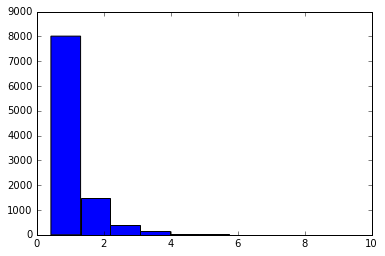

In [13]:
plt.figure()
plt.hist(article_weights*10000)
plt.show()

#### ILLUSTRATION BLOCK : Here you can play with the triplet maker and see what gives triplet labelisation 

In [14]:
triplets, labels = create_triplets(d2v_model, article_names, article_weights, nb_triplets=25, triplets_per_file=8, neg_ratio=1, str_mode = True)

for i in range(len(labels)):
    print 50*'-'
    print "label = ", labels[i]
    print "\nquery :", triplets[i][0]
    print "\npartial summary :", triplets[i][1]
    print "\ncandidate :", triplets[i][2]

--------------------------------------------------
label =  1

query : New York State Route 98

partial summary : S Most of the route passes through rural, undeveloped areas; however, in southern Genesee County, it traverses more urbanized areas that lie in and around Batavia
Most of modern NY 98 north of Batavia was originally designated as New York State Route 74 in the mid-1920s It was extended south to US 20 (now US 20A) in Varysburg in the late 1920s Other changes, including a pair of substantial realignments, have also occurred in the time since the route was originally assigned

candidate :  The northern end is at an interchange with the Lake Ontario State Parkway in the town of Carlton in Orleans County, near the southern shore of Lake Ontario
--------------------------------------------------
label =  0

query : New York State Route 98

partial summary :  The southern terminus of the route is at an intersection with U Most of the route passes through rural, undeveloped areas; 

#### Define model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam


fc_model_name = nn_models_folder + time.strftime("%Y_%m_%d_") +'_fc_model.h5' # replace it with hour of training

fc_model = Sequential()

fc_model.add(Dense(120, input_dim=1200))
fc_model.add(Activation('sigmoid'))
fc_model.add(Dropout(0.5))

fc_model.add(Dense(12))
fc_model.add(Activation('sigmoid'))
fc_model.add(Dropout(0.5))

fc_model.add(Dense(1))
fc_model.add(Activation('sigmoid'))

In [25]:
fc_model.compile(loss="binary_crossentropy", optimizer='sgd')

#### Training (we use training per batch)

In [26]:
batch_size = 128
for i in range(200):
    if i%10 == 0 : 
        print(i)
    triplets, labels = create_triplets(d2v_model, article_names, article_weights, nb_triplets=batch_size, triplets_per_file=16, neg_ratio=1, str_mode = False)
    fc_model.train_on_batch(triplets, labels)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [12]:
triplets_tests , labels_tests = create_triplets(d2v_model, article_names, article_weights, nb_triplets=128, triplets_per_file=16, neg_ratio=1, str_mode = False)
labels_predicted = fc_model.predict(triplets_tests , batch_size=batch_size, verbose=1)

128/128 [==============================] - 0s


In [19]:
X_val = np.load("/home/ubuntu/summarization_query_oriented/valset/X_val.npy")
y_val = np.load("/home/ubuntu/summarization_query_oriented/valset/y_val.npy")

In [27]:
loss_and_metrics = fc_model.evaluate(X_val,y_val, batch_size = 100)

 9600/10000 [===========================>..] - ETA: 0s

In [29]:
type(loss_and_metrics)

numpy.float64

In [13]:
loss_and_metrics = fc_model.evaluate(triplets_tests, labels_tests, batch_size=batch_size)
print(loss_and_metrics)

128/128 [==============================] - 0s
0.690462529659


In [14]:
labels_tests

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

#### Saving

In [15]:
from keras.models import load_model

fc_model.save(fc_model_name)  # creates a HDF5 file 'my_model.h5'

del fc_model  # deletes the existing model
# returns a compiled model
# identical to the previous one
fc_model = load_model(fc_model_name)

In [16]:
fc_model = load_model(fc_model_name)

#### General info on the model

In [17]:
print(fc_model.summary())
print(fc_model.get_config())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 120)           144120      dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 120)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 120)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 12)            1452        dropout_1[0][0]                  
___________________________________________________________________________________________

#### Testing the model

In [52]:
def summarize(text, query, d2v_model, nn_model, limit = 250):

    query_prep = gensim.utils.simple_preprocess(query, deacc=True)
    query_vector = d2v_model.infer_vector(query_prep)
    
    summary  = ""
    summary_vector = d2v_model.infer_vector([""])
    summary_idx = []
    
    sentences = text.split('.')
    sentences = np.asarray(sentences)
    
    remaining_sentences = copy.copy(sentences)
    
    size = 0
    counter = 0
    while size < limit and len(remaining_sentences)>0 :
        counter = counter+1
        scores = []
        for sentence in remaining_sentences :
            
            
            sentence_prep = gensim.utils.simple_preprocess(sentence, deacc=True)
            sentence_vector = d2v_model.infer_vector(sentence_prep)

            nn_input = np.hstack([query_vector, summary_vector, sentence_vector])
            nn_input = np.asarray([nn_input]) # weird but it is important to do it
            score = nn_model.predict(nn_input) 
            scores.append(score)
        #print(scores)
        max_idx_rem = int(np.argmax(scores))
        idx_selected_sentence = np.arange(len(sentences))[sentences == remaining_sentences[max_idx_rem]]
        idx_selected_sentence = int(idx_selected_sentence[0])
        size += len(remaining_sentences[max_idx_rem].split())
        
        remaining_sentences = list(remaining_sentences)
        del remaining_sentences[max_idx_rem]
        bisect.insort_left(summary_idx,idx_selected_sentence)

        summary  = ""

        for idx in summary_idx:
            summary = summary + " " + sentences[idx]

        summary_prep = gensim.utils.simple_preprocess(summary, deacc=True)
        summary_vector = d2v_model.infer_vector(summary_prep)

    return summary

#### On wikipedia article

In [58]:
wikipedia_title = "History of Israel"
with open(data_json+wikipedia_title+".json", 'r') as f:
    wiki_as_json = json.load(f)

text = ""
for key in wiki_as_json.keys():
    if key not in non_selected_keys:
        text += " " + wiki_as_json[key]
        
random_idx = np.random.randint(0,len(wiki_as_json.keys()))
query = wiki_as_json.keys()[random_idx]
summary_true = wiki_as_json[query]
limit_size = len(wiki_as_json[query].split())

print 50*"*"
print 'query', query
print 50*"*"
print "real summary\n\n", summary_true
print 50*"*"
print "nn summary\n\n", summarize(text,query,d2v_model, fc_model, limit = limit_size)

**************************************************
query History of Israel Babylonian rule (586–538 BCE)
**************************************************
real summary

In 586 BCE King Nebuchadnezzar II of Babylon conquered Judah. According to the Hebrew Bible, he destroyed Solomon's Temple and exiled the Jews to Babylon. The defeat was also recorded by the Babylonians (see the Babylonian Chronicles). Babylonian and Biblical sources suggest that the Judean king, Jehoiachin, switched allegiances between the Egyptians and the Babylonians and that invasion was a punishment for allying with Babylon's principal rival, Egypt. The exiled Jews may have been restricted to the elite.
Jehoiachin was eventually released by the Babylonians (see Jehoiachin's Rations Tablets) and according to both the Bible and the Talmud, the Judean royal family (the Davidic line) continued as head of the exile in Babylon (the Exilarch).
**************************************************
nn summary

31
64
83
116
  

#### on duc dataset

In [40]:
import pyrouge
import re
import os

title_file = "/home/ubuntu/summarization_query_oriented/DUC/duc2005_topics.sgml"
titles_folder = "/home/ubuntu/summarization_query_oriented/DUC/duc2005_docs/"

In [41]:
def doc_title_table(title_file):
    with open(title_file , 'r') as f :
        lines = f.readlines()
        raw_text = "".join(l for l in lines)
        left_idx_num = [ m.end(0) for m in re.finditer(r"<num>",raw_text)]
        right_idx_num = [ m.start(0) for m in re.finditer(r"</num>",raw_text)]

        left_idx_title = [ m.end(0) for m in re.finditer(r"<title>",raw_text)]
        right_idx_title = [ m.start(0) for m in re.finditer(r"</title>",raw_text)]

        docs_title_dict = {}
        for i in range(len(left_idx_num)):
            docs_title_dict[raw_text[left_idx_num[i]+1:right_idx_num[i]-1]] = raw_text[left_idx_title[i]+1:right_idx_title[i]-1]
    return docs_title_dict

def merge_articles(docs_folder):

    s = ""
    
    for doc in os.listdir(docs_folder):

        with open(docs_folder + doc ,'r') as f:

            lines = f.readlines()
            raw_doc = "".join(txt for txt in lines)
            left_idx_headline = [ m.end(0) for m in re.finditer(r"<HEADLINE>",raw_doc)]
            right_idx_headline = [ m.start(0) for m in re.finditer(r"</HEADLINE>",raw_doc)]

            left_idx_text = [ m.end(0) for m in re.finditer(r"<TEXT>",raw_doc)]
            right_idx_text = [ m.start(0) for m in re.finditer(r"</TEXT>",raw_doc)]

            raw_headline = raw_doc[left_idx_headline[0]:right_idx_headline[0]]
            raw_text = raw_doc[left_idx_text[0]:right_idx_text[0]]

            left_idx_paragraph_headline = [ m.end(0) for m in re.finditer(r"<P>",raw_headline)]
            right_idx_paragraph_headline = [ m.start(0) for m in re.finditer(r"</P>",raw_headline)]

            left_idx_paragraph_text = [ m.end(0) for m in re.finditer(r"<P>",raw_text)]
            right_idx_paragraph_text = [ m.start(0) for m in re.finditer(r"</P>",raw_text)]

            for i in range(len(left_idx_paragraph_headline)):
                s += raw_headline[left_idx_paragraph_headline[i]:right_idx_paragraph_headline[i]-2] + "."

            for i in range(len(left_idx_paragraph_text)):
                s += raw_text[left_idx_paragraph_text[i]:right_idx_paragraph_text[i]-1]

    return s

In [36]:
docs_title = doc_title_table(title_file)

In [37]:
docs_key = docs_title.keys()[0]
query = docs_title[docs_key]
docs_folder = titles_folder+docs_key+"/"
text = merge_articles(docs_folder)

In [55]:
print query
print 50*'*'
summary = summarize(text,query,d2v_model, fc_model, limit = 250)
print summary

journalist risks
**************************************************
41
67
98
127
179
225
243
285
 
After a yearlong reign of terror by government-backed death squads that emptied 
villages of young men and littered Sri Lanka's beaches with corpses, the 
fishermen of Moratuwa were hardly surprised when they spotted yet another body 
floating 250 yards offshore recently  
The word was out that De Zoysa had helped produce a satirical play that was 
savagely critical of Premadasa, who has been so sensitive to personal criticism 
that he has barred at least two foreign journalists from Sri Lanka simply for 
writing about his low-caste roots  
Last month, Badr, 63, survived what appeared to be an assassination attempt 
when a car bomb exploded just before he arrived at a police recreational 
facility  
The determination to fight with the pen is certainly what drives the Colombian 
journalism fraternity, which has made a greater sacrifice than any other 
national group: 19 journalists were mu

In [59]:
print len(summary.split())

285


In [61]:
# system dir 
system_folder = "/home/ubuntu/summarization_query_oriented/DUC/duc2005_summary_system/first_try/"


In [ ]:
for docs_key in docs_title.keys():
    try :
        docs_folder = titles_folder+docs_key+"/"
        text = merge_articles(docs_folder)
        summary = summarize(text,query,d2v_model, fc_model, limit = 250)

        summary = " ".join(summary.split()[:250])

        with open(system_folder+docs_key,'w') as f :
            f.write(summary)
    except:
        pass

26
67
109
145
176
201
230
276
44
74
114
148
172
213
242
262
34
104
132
166
206
236
266
0
28
46
66
78
100
109
143
177
229
258
41
66
100
146
182
224
248
276
0
0
33
65
101
116
132
162
206
224
248
288

In [68]:
query

u'History of Israel Babylonian rule (586\u2013538 BCE)'

#### pyrouge

In [3]:
from pyrouge import Rouge155

r = Rouge155()
r.system_dir = '/home/ubuntu/summarization_query_oriented/DUC/duc2005_summary_system/first_try'
r.model_dir = '/home/ubuntu/summarization_query_oriented/DUC/duc2005_summary_model'
r.system_filename_pattern = 'd(\d+)[a-z]'
r.model_filename_pattern = 'D#ID#.M.250.[A-Z].[A-Z]'

output = r.convert_and_evaluate()
print(output)
output_dict = r.output_to_dict(output)

2016-08-28 07:51:47,742 [MainThread  ] [INFO ]  Writing summaries.
INFO:global:Writing summaries.
2016-08-28 07:51:47,743 [MainThread  ] [INFO ]  Processing summaries. Saving system files to /tmp/tmpx8vS_G/system and model files to /tmp/tmpx8vS_G/model.
INFO:global:Processing summaries. Saving system files to /tmp/tmpx8vS_G/system and model files to /tmp/tmpx8vS_G/model.
2016-08-28 07:51:47,744 [MainThread  ] [INFO ]  Processing files in /home/ubuntu/summarization_query_oriented/DUC/duc2005_summary_system/first_try.
INFO:global:Processing files in /home/ubuntu/summarization_query_oriented/DUC/duc2005_summary_system/first_try.
2016-08-28 07:51:47,745 [MainThread  ] [INFO ]  Processing d413a.
INFO:global:Processing d413a.
2016-08-28 07:51:47,746 [MainThread  ] [INFO ]  Processing d345j.
INFO:global:Processing d345j.
2016-08-28 07:51:47,747 [MainThread  ] [INFO ]  Processing d654f.
INFO:global:Processing d654f.
2016-08-28 07:51:47,748 [MainThread  ] [INFO ]  Processing d376e.
INFO:global:

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d413a
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d345j
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d654f
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d376e
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d391h
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d446j
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d383j
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d370i
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d633g
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
d332h
/home/ubuntu/anaconda2/lib/python2.7/site-packages

2016-08-28 07:51:47,798 [MainThread  ] [INFO ]  Processing D426.M.250.A.C.
INFO:global:Processing D426.M.250.A.C.
2016-08-28 07:51:47,799 [MainThread  ] [INFO ]  Processing D301.M.250.I.A.
INFO:global:Processing D301.M.250.I.A.
2016-08-28 07:51:47,800 [MainThread  ] [INFO ]  Processing D407.M.250.B.G.
INFO:global:Processing D407.M.250.B.G.
2016-08-28 07:51:47,801 [MainThread  ] [INFO ]  Processing D350.M.250.A.B.
INFO:global:Processing D350.M.250.A.B.
2016-08-28 07:51:47,802 [MainThread  ] [INFO ]  Processing D370.M.250.I.D.
INFO:global:Processing D370.M.250.I.D.
2016-08-28 07:51:47,803 [MainThread  ] [INFO ]  Processing D426.M.250.A.H.
INFO:global:Processing D426.M.250.A.H.
2016-08-28 07:51:47,804 [MainThread  ] [INFO ]  Processing D632.M.250.I.B.
INFO:global:Processing D632.M.250.I.B.
2016-08-28 07:51:47,805 [MainThread  ] [INFO ]  Processing D428.M.250.E.G.
INFO:global:Processing D428.M.250.E.G.
2016-08-28 07:51:47,806 [MainThread  ] [INFO ]  Processing D311.M.250.I.E.
INFO:global:P


D346.M.250.H.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D426.M.250.A.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D301.M.250.I.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D407.M.250.B.G
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D350.M.250.A.B
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D370.M.250.I.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D426.M.250.A.H
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D632.M.250.I.B
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D428.M.250.E.G
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D311.M.250.I.E
/home/ubuntu/anaconda2/lib/python2.7/site-packag

2016-08-28 07:51:47,849 [MainThread  ] [INFO ]  Processing D413.M.250.A.F.
INFO:global:Processing D413.M.250.A.F.
2016-08-28 07:51:47,850 [MainThread  ] [INFO ]  Processing D376.M.250.E.A.
INFO:global:Processing D376.M.250.E.A.
2016-08-28 07:51:47,851 [MainThread  ] [INFO ]  Processing D350.M.250.A.A.
INFO:global:Processing D350.M.250.A.A.
2016-08-28 07:51:47,852 [MainThread  ] [INFO ]  Processing D407.M.250.B.E.
INFO:global:Processing D407.M.250.B.E.
2016-08-28 07:51:47,853 [MainThread  ] [INFO ]  Processing D313.M.250.E.C.
INFO:global:Processing D313.M.250.E.C.
2016-08-28 07:51:47,854 [MainThread  ] [INFO ]  Processing D422.M.250.C.J.
INFO:global:Processing D422.M.250.C.J.
2016-08-28 07:51:47,856 [MainThread  ] [INFO ]  Processing D407.M.250.B.C.
INFO:global:Processing D407.M.250.B.C.
2016-08-28 07:51:47,857 [MainThread  ] [INFO ]  Processing D431.M.250.H.A.
INFO:global:Processing D431.M.250.H.A.
2016-08-28 07:51:47,858 [MainThread  ] [INFO ]  Processing D422.M.250.C.C.
INFO:global:P


D321.M.250.F.F
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D413.M.250.A.F
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D376.M.250.E.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D350.M.250.A.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D407.M.250.B.E
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D313.M.250.E.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D422.M.250.C.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D407.M.250.B.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D431.M.250.H.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D422.M.250.C.C
/home/ubuntu/anaconda2/lib/python2.7/site-packag

2016-08-28 07:51:47,900 [MainThread  ] [INFO ]  Processing D400.M.250.B.A.
INFO:global:Processing D400.M.250.B.A.
2016-08-28 07:51:47,901 [MainThread  ] [INFO ]  Processing D671.M.250.G.D.
INFO:global:Processing D671.M.250.G.D.
2016-08-28 07:51:47,903 [MainThread  ] [INFO ]  Processing D360.M.250.F.G.
INFO:global:Processing D360.M.250.F.G.
2016-08-28 07:51:47,904 [MainThread  ] [INFO ]  Processing D683.M.250.J.F.
INFO:global:Processing D683.M.250.J.F.
2016-08-28 07:51:47,905 [MainThread  ] [INFO ]  Processing D324.M.250.E.J.
INFO:global:Processing D324.M.250.E.J.
2016-08-28 07:51:47,906 [MainThread  ] [INFO ]  Processing D311.M.250.I.H.
INFO:global:Processing D311.M.250.I.H.
2016-08-28 07:51:47,907 [MainThread  ] [INFO ]  Processing D683.M.250.J.J.
INFO:global:Processing D683.M.250.J.J.
2016-08-28 07:51:47,908 [MainThread  ] [INFO ]  Processing D632.M.250.I.H.
INFO:global:Processing D632.M.250.I.H.
2016-08-28 07:51:47,909 [MainThread  ] [INFO ]  Processing D400.M.250.B.E.
INFO:global:P


D391.M.250.H.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D400.M.250.B.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D671.M.250.G.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D360.M.250.F.G
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D683.M.250.J.F
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D324.M.250.E.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D311.M.250.I.H
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D683.M.250.J.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D632.M.250.I.H
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D400.M.250.B.E
/home/ubuntu/anaconda2/lib/python2.7/site-packag

2016-08-28 07:51:47,952 [MainThread  ] [INFO ]  Processing D350.M.250.A.C.
INFO:global:Processing D350.M.250.A.C.
2016-08-28 07:51:47,953 [MainThread  ] [INFO ]  Processing D446.M.250.J.H.
INFO:global:Processing D446.M.250.J.H.
2016-08-28 07:51:47,954 [MainThread  ] [INFO ]  Processing D391.M.250.H.H.
INFO:global:Processing D391.M.250.H.H.
2016-08-28 07:51:47,955 [MainThread  ] [INFO ]  Processing D671.M.250.G.G.
INFO:global:Processing D671.M.250.G.G.
2016-08-28 07:51:47,956 [MainThread  ] [INFO ]  Processing D695.M.250.C.D.
INFO:global:Processing D695.M.250.C.D.
2016-08-28 07:51:47,957 [MainThread  ] [INFO ]  Processing D671.M.250.G.B.
INFO:global:Processing D671.M.250.G.B.
2016-08-28 07:51:47,958 [MainThread  ] [INFO ]  Processing D345.M.250.J.I.
INFO:global:Processing D345.M.250.J.I.
2016-08-28 07:51:47,959 [MainThread  ] [INFO ]  Processing D393.M.250.F.B.
INFO:global:Processing D393.M.250.F.B.
2016-08-28 07:51:47,961 [MainThread  ] [INFO ]  Processing D446.M.250.J.G.
INFO:global:P


D446.M.250.J.I
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D350.M.250.A.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D446.M.250.J.H
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D391.M.250.H.H
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D671.M.250.G.G
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D695.M.250.C.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D671.M.250.G.B
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D345.M.250.J.I
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D393.M.250.F.B
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D446.M.250.J.G
/home/ubuntu/anaconda2/lib/python2.7/site-packag

2016-08-28 07:51:48,003 [MainThread  ] [INFO ]  Processing D345.M.250.J.B.
INFO:global:Processing D345.M.250.J.B.
2016-08-28 07:51:48,004 [MainThread  ] [INFO ]  Processing D391.M.250.H.G.
INFO:global:Processing D391.M.250.H.G.
2016-08-28 07:51:48,006 [MainThread  ] [INFO ]  Processing D695.M.250.C.J.
INFO:global:Processing D695.M.250.C.J.
2016-08-28 07:51:48,007 [MainThread  ] [INFO ]  Processing D343.M.250.C.A.
INFO:global:Processing D343.M.250.C.A.
2016-08-28 07:51:48,008 [MainThread  ] [INFO ]  Processing D321.M.250.F.B.
INFO:global:Processing D321.M.250.F.B.
2016-08-28 07:51:48,009 [MainThread  ] [INFO ]  Processing D376.M.250.E.D.
INFO:global:Processing D376.M.250.E.D.
2016-08-28 07:51:48,010 [MainThread  ] [INFO ]  Processing D683.M.250.J.A.
INFO:global:Processing D683.M.250.J.A.
2016-08-28 07:51:48,011 [MainThread  ] [INFO ]  Processing D408.M.250.C.C.
INFO:global:Processing D408.M.250.C.C.
2016-08-28 07:51:48,012 [MainThread  ] [INFO ]  Processing D435.M.250.F.F.
INFO:global:P


D413.M.250.A.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D345.M.250.J.B
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D391.M.250.H.G
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D695.M.250.C.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D343.M.250.C.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D321.M.250.F.B
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D376.M.250.E.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D683.M.250.J.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D408.M.250.C.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D435.M.250.F.F
/home/ubuntu/anaconda2/lib/python2.7/site-packag

2016-08-28 07:51:48,055 [MainThread  ] [INFO ]  Processing D654.M.250.F.A.
INFO:global:Processing D654.M.250.F.A.
2016-08-28 07:51:48,056 [MainThread  ] [INFO ]  Processing D347.M.250.B.D.
INFO:global:Processing D347.M.250.B.D.
2016-08-28 07:51:48,057 [MainThread  ] [INFO ]  Processing D354.M.250.C.E.
INFO:global:Processing D354.M.250.C.E.
2016-08-28 07:51:48,058 [MainThread  ] [INFO ]  Processing D683.M.250.J.C.
INFO:global:Processing D683.M.250.J.C.
2016-08-28 07:51:48,059 [MainThread  ] [INFO ]  Processing D426.M.250.A.D.
INFO:global:Processing D426.M.250.A.D.
2016-08-28 07:51:48,060 [MainThread  ] [INFO ]  Processing D436.M.250.J.I.
INFO:global:Processing D436.M.250.J.I.
2016-08-28 07:51:48,061 [MainThread  ] [INFO ]  Processing D408.M.250.C.J.
INFO:global:Processing D408.M.250.C.J.
2016-08-28 07:51:48,062 [MainThread  ] [INFO ]  Processing D407.M.250.B.I.
INFO:global:Processing D407.M.250.B.I.
2016-08-28 07:51:48,064 [MainThread  ] [INFO ]  Processing D408.M.250.C.I.
INFO:global:P


D354.M.250.C.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D654.M.250.F.A
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D347.M.250.B.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D354.M.250.C.E
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D683.M.250.J.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D426.M.250.A.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D436.M.250.J.I
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D408.M.250.C.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D407.M.250.B.I
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D408.M.250.C.I
/home/ubuntu/anaconda2/lib/python2.7/site-packag

2016-08-28 07:51:48,106 [MainThread  ] [INFO ]  Processing D347.M.250.B.C.
INFO:global:Processing D347.M.250.B.C.
2016-08-28 07:51:48,107 [MainThread  ] [INFO ]  Processing D633.M.250.G.E.
INFO:global:Processing D633.M.250.G.E.
2016-08-28 07:51:48,108 [MainThread  ] [INFO ]  Processing D671.M.250.G.J.
INFO:global:Processing D671.M.250.G.J.
2016-08-28 07:51:48,109 [MainThread  ] [INFO ]  Processing D343.M.250.C.C.
INFO:global:Processing D343.M.250.C.C.
2016-08-28 07:51:48,111 [MainThread  ] [INFO ]  Processing D366.M.250.I.H.
INFO:global:Processing D366.M.250.I.H.
2016-08-28 07:51:48,112 [MainThread  ] [INFO ]  Processing D633.M.250.G.D.
INFO:global:Processing D633.M.250.G.D.
2016-08-28 07:51:48,113 [MainThread  ] [INFO ]  Processing D407.M.250.B.J.
INFO:global:Processing D407.M.250.B.J.
2016-08-28 07:51:48,114 [MainThread  ] [INFO ]  Processing D400.M.250.B.D.
INFO:global:Processing D400.M.250.B.D.
2016-08-28 07:51:48,115 [MainThread  ] [INFO ]  Processing D360.M.250.F.F.
INFO:global:P


D438.M.250.G.H
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D347.M.250.B.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D633.M.250.G.E
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D671.M.250.G.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D343.M.250.C.C
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D366.M.250.I.H
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D633.M.250.G.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D407.M.250.B.J
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D400.M.250.B.D
/home/ubuntu/anaconda2/lib/python2.7/site-packages/pyrouge/utils/file_utils.py ligne 28:
D360.M.250.F.F
/home/ubuntu/anaconda2/lib/python2.7/site-packag

In [4]:
print output_dict

{u'rouge_3_f_score_cb': 0.06219, u'rouge_3_f_score_ce': 0.06973, u'rouge_1_precision': 0.52241, u'rouge_l_precision_cb': 0.40339, u'rouge_l_f_score_cb': 0.19119, u'rouge_l_precision_ce': 0.57492, u'rouge_3_recall': 0.04781, u'rouge_3_precision_ce': 0.39223, u'rouge_w_1.2_f_score_ce': 0.07739, u'rouge_s*_f_score_ce': 0.07099, u'rouge_2_precision_ce': 0.43138, u'rouge_2_precision_cb': 0.22056, u'rouge_2_recall': 0.06422, u'rouge_w_1.2_f_score_cb': 0.06653, u'rouge_3_precision_cb': 0.18275, u'rouge_4_f_score_ce': 0.06124, u'rouge_2_precision': 0.32166, u'rouge_1_recall_cb': 0.16669, u'rouge_1_recall_ce': 0.21293, u'rouge_s*_precision': 0.35415, u'rouge_4_f_score_cb': 0.05431, u'rouge_s*_recall_cb': 0.03628, u'rouge_su*_recall_ce': 0.05173, u'rouge_w_1.2_f_score': 0.07203, u'rouge_w_1.2_recall': 0.04654, u'rouge_su*_recall_cb': 0.03687, u'rouge_l_precision': 0.48533, u'rouge_2_recall_cb': 0.06094, u'rouge_s*_precision_ce': 0.4663, u'rouge_2_recall_ce': 0.06762, u'rouge_4_precision_cb': 0.1